In [ ]:
!pip install lightkurve
!pip install batman-package
!pip install pandas
!pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.2 MB/s eta 0:00:00


In [ ]:
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

search_result = lk.search_lightcurve('TIC 307210830',exptime = 120, author = 'SPOC')
lc_collection = search_result.download_all(quality_bitmask='hardest')
lcu = lc_collection.stitch().remove_nans()

new_flux = lcu.flux.value
new_flux = np.ma.filled(new_flux, fill_value=np.nan)
new_time = lcu.time.value
new_error = lcu.flux_err.value
new_error = np.ma.filled(new_error, fill_value=np.nan)


new_array = [new_time, new_flux, new_error]
print(new_array)

np.savetxt('new_array.txt', np.column_stack((new_time, new_flux, new_error)), delimiter = ',', header = 'time,flux,flux_err', comments = '')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[array([1354.10741134, 1354.1088002 , 1354.11018906, ..., 3206.41040322,
       3206.41179209, 3206.41318096]), array([1.0003744 , 1.0012105 , 1.0003825 , ..., 1.000919  , 0.99974024,
       1.0005842 ], dtype=float32), array([0.00076571, 0.00076591, 0.00076605, ..., 0.00082745, 0.00082725,
       0.00082765], dtype=float32)]


In [ ]:
import lmfit as lm
import batman
import numpy as np

from lmfit import fit_report
from lmfit import minimize, Parameters

from astropy import constants as const
from astropy import units as uu

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

period = np.linspace(1, 20, 10000)
bls = lcu.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

new_time, new_flux, new_error = np.genfromtxt('drive/MyDrive/Colab Notebooks/new_array.txt', unpack=True, delimiter=',')
nans = np.isnan(new_time) | np.isnan(new_flux) | np.isnan(new_error)
new_time, new_flux, new_error = new_time[~nans], new_flux[~nans], new_error[~nans]

paramslm = Parameters()
paramslm.add('t', value = 3.6906 , vary = True, min = 3.68, max =3.70)
paramslm.add('m', value = 0.3 , vary = False)
paramslm.add('w', value = 90, vary = False)
paramslm.add('rpl',value = 0.3 , vary = True, min =0.2 , max = 0.4 )
paramslm.add('rs', value = 0.3, vary = False )
paramslm.add('inc', value =88 , vary = False )
paramslm.add('ecc', value =0.15792030666666668 , vary = True, min = 0.15, max = 0.16)
paramslm.add('t0', value = 1356.2174113410244 , vary = True, min = 1350, max = 1360)

#t0=vary,
def keplers_3rd_law(m,t):
    time = t*86400
    mass = m*1.989*10**30
    g = 6.67430*10**(-11)
    a = ((time**2)*g*mass)/(4*(np.pi**2))
    return a**(1/3)/(0.3*6.96*(10**8))

def rp_ratio(rpl,rs):
    return ((rpl*6378)/(rs*6.96*(10**5)))

def model_function(paramslm, new_time, error, data = None):
  vals = paramslm.valuesdict()
  t = vals['t']
  m = vals['m']
  w = vals['w']
  rpl = vals['rpl']
  rs = vals['rs']
  inc = vals['inc']
  ecc = vals['ecc']
  t0 = vals['t0']
 # frac_rp = vals['frac_rp']

  ax = keplers_3rd_law(m = m , t = t )
  rp = rp_ratio(rpl = rpl ,rs = rs )

#batman package starts here:


  params = batman.TransitParams()       #object to store transit parameters
  params.t0 = t0                        #time of inferior conjunction
  params.per = t                      #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = ax                        #semi-major axis (in units of stellar radii)
  params.inc = inc                     #orbital inclination (in degrees)
  params.ecc = ecc                     #eccentricity
  params.w = 90.                        #longitude of periastron (in degrees)
  params.limb_dark = "quadratic"        #limb darkening model
  params.u = [0.2,0.2]

  model = batman.TransitModel(params, new_time)

  m_flux = model.light_curve(params)

  if data is None:
        return m_flux
  else:
        return m_flux-data



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`period` contains 130379 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


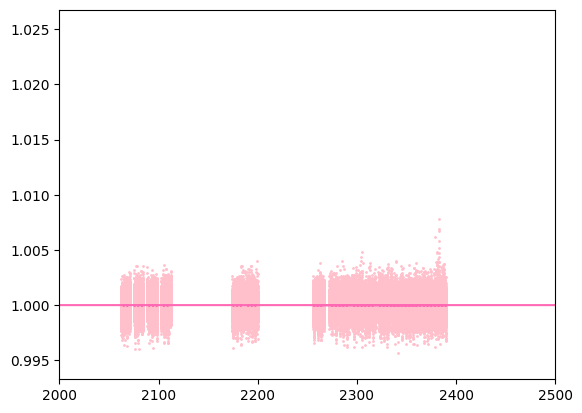

In [ ]:

m_flux = model_function(paramslm, new_time, new_error)
plt.plot(new_time, m_flux, color= 'hotpink')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(2000,2500)
plt.show()


In [ ]:
out = minimize(model_function, paramslm, args=(new_time, new_error), kws={'data': new_flux}, nan_policy='omit')
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 146
    # data points      = 336256
    # variables        = 4
    chi-square         = 0.22921316
    reduced chi-square = 6.8167e-07
    Akaike info crit   = -4774400.47
    Bayesian info crit = -4774357.57
[[Variables]]
    t:    3.69064690 +/- 2.5999e-06 (0.00%) (init = 3.6906)
    m:    0.3 (fixed)
    w:    90 (fixed)
    rpl:  0.39999803 +/- 0.02099895 (5.25%) (init = 0.3)
    rs:   0.3 (fixed)
    inc:  88 (fixed)
    ecc:  0.15999969 +/- 0.47705961 (298.16%) (init = 0.1579203)
    t0:   1356.20804 +/- 7.4771e-04 (0.00%) (init = 1356.217)
[[Correlations]] (unreported correlations are < 0.100)
    C(t, t0)    = -0.8256
    C(rpl, ecc) = +0.2870
